## Problem Statement 

You need to build a model that is able to classify customer complaints based on the products/services. By doing so, you can segregate these tickets into their relevant categories and, therefore, help in the quick resolution of the issue.

You will be doing topic modelling on the <b>.json</b> data provided by the company. Since this data is not labelled, you need to apply NMF to analyse patterns and classify tickets into the following five clusters based on their products/services:

* Credit card / Prepaid card

* Bank account services

* Theft/Dispute reporting

* Mortgages/loans

* Others 


With the help of topic modelling, you will be able to map each ticket onto its respective department/category. You can then use this data to train any supervised model such as logistic regression, decision tree or random forest. Using this trained model, you can classify any new customer complaint support ticket into its relevant department.

## Pipelines that needs to be performed:

You need to perform the following eight major tasks to complete the assignment:

1.  Data loading

2. Text preprocessing

3. Exploratory data analysis (EDA)

4. Feature extraction

5. Topic modelling 

6. Model building using supervised learning

7. Model training and evaluation

8. Model inference

## Importing the necessary libraries

In [1]:
import json 
import numpy as np
import pandas as pd
import re, nltk, spacy, string
import en_core_web_sm
nlp = en_core_web_sm.load()
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from plotly.offline import plot
import plotly.graph_objects as go
import plotly.express as px

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from pprint import pprint

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/labuser/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/labuser/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/labuser/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/labuser/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Loading the data

The data is in JSON format and we need to convert it to a dataframe.

In [2]:
# Opening JSON file 
f = open("./complaints.json")# Write the path to your data file and load it 
  
# returns JSON object as  
# a dictionary 
data = json.load(f)
df=pd.json_normalize(data)

## Data preparation

In [3]:
# Inspect the dataframe to understand the given data.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
print(df.shape)
df.head()

(78313, 22)


,_index,_type,_id,_score,_source.tags,_source.zip_code,_source.complaint_id,_source.issue,_source.date_received,_source.state,_source.consumer_disputed,_source.product,_source.company_response,_source.company,_source.submitted_via,_source.date_sent_to_company,_source.company_public_response,_source.sub_product,_source.timely,_source.complaint_what_happened,_source.sub_issue,_source.consumer_consent_provided
0,complaint-public-v2,complaint,3211475,0.0,None,90301,3211475,Attempts to collect debt not owed,2019-04-13T12:00:00-05:00,CA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-13T12:00:00-05:00,None,Credit card debt,Yes,,Debt is not yours,Consent not provided
1,complaint-public-v2,complaint,3229299,0.0,Servicemember,319XX,3229299,Written notification about debt,2019-05-01T12:00:00-05:00,GA,N/A,Debt collection,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-05-01T12:00:00-05:00,None,Credit card debt,Yes,Good morning my name is XXXX XXXX and I apprec...,Didn't receive enough information to verify debt,Consent provided
2,complaint-public-v2,complaint,3199379,0.0,None,77069,3199379,"Other features, terms, or problems",2019-04-02T12:00:00-05:00,TX,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Web,2019-04-02T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,I upgraded my XXXX XXXX card in XX/XX/2018 and...,Problem with rewards from credit card,Consent provided
3,complaint-public-v2,complaint,2673060,0.0,None,48066,2673060,Trouble during payment process,2017-09-13T12:00:00-05:00,MI,N/A,Mortgage,Closed with explanation,JPMORGAN CHASE & CO.,Web,2017-09-14T12:00:00-05:00,None,Conventional home mortgage,Yes,,None,Consent not provided
4,complaint-public-v2,complaint,3203545,0.0,None,10473,3203545,Fees or interest,2019-04-05T12:00:00-05:00,NY,N/A,Credit card or prepaid card,Closed with explanation,JPMORGAN CHASE & CO.,Referral,2019-04-05T12:00:00-05:00,None,General-purpose credit card or charge card,Yes,,Charged too much interest,N/A


In [4]:
#print the column names
print(len(df.columns))
df.columns

22


Index(['_index', '_type', '_id', '_score', '_source.tags', '_source.zip_code',
       '_source.complaint_id', '_source.issue', '_source.date_received',
       '_source.state', '_source.consumer_disputed', '_source.product',
       '_source.company_response', '_source.company', '_source.submitted_via',
       '_source.date_sent_to_company', '_source.company_public_response',
       '_source.sub_product', '_source.timely',
       '_source.complaint_what_happened', '_source.sub_issue',
       '_source.consumer_consent_provided'],
      dtype='object')

In [5]:
#Assign new column names

df.columns = list(map(lambda x : x.lstrip('_') if x.startswith('_') else x, list(df.columns)))

df.columns = list(map(lambda x : x.replace('source.', "") if x.startswith('source.') else x, df.columns))

print(len(df.columns))
df.columns

22


Index(['index', 'type', 'id', 'score', 'tags', 'zip_code', 'complaint_id',
       'issue', 'date_received', 'state', 'consumer_disputed', 'product',
       'company_response', 'company', 'submitted_via', 'date_sent_to_company',
       'company_public_response', 'sub_product', 'timely',
       'complaint_what_happened', 'sub_issue', 'consumer_consent_provided'],
      dtype='object')

In [6]:
# Check the % missing values
round(100*(df.isnull().sum()/len(df)), 2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened       0.00
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64

In [7]:
#Assign nan in place of blanks in the complaints column
df['complaint_what_happened'] = df['complaint_what_happened'].apply(lambda x : np.nan if x == "" else x)

In [8]:
# check the missing values again
round(100*(df.isnull().sum()/len(df)), 2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         86.08
zip_code                      8.63
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         2.54
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  13.50
timely                        0.00
complaint_what_happened      73.09
sub_issue                    59.12
consumer_consent_provided     1.29
dtype: float64

In [9]:
#Remove all rows where complaints column is nan
df_final = df[~(df.complaint_what_happened.isna())]


In [10]:
# Check the % of missing values again
round(100*(df_final.isnull().sum()/len(df_final)), 2)

index                         0.00
type                          0.00
id                            0.00
score                         0.00
tags                         81.89
zip_code                     22.04
complaint_id                  0.00
issue                         0.00
date_received                 0.00
state                         0.68
consumer_disputed             0.00
product                       0.00
company_response              0.00
company                       0.00
submitted_via                 0.00
date_sent_to_company          0.00
company_public_response      99.99
sub_product                  10.01
timely                        0.00
complaint_what_happened       0.00
sub_issue                    38.80
consumer_consent_provided     0.00
dtype: float64

In [11]:
# Final shape of the dataframe after removing NaN values
df_final.shape

(21072, 22)

## Prepare the text for topic modeling

Once you have removed all the blank complaints, you need to:

* Make the text lowercase
* Remove text in square brackets
* Remove punctuation
* Remove words containing numbers


Once you have done these cleaning operations you need to perform the following:
* Lemmatize the texts
* Extract the POS tags of the lemmatized text and remove all the words which have tags other than NN[tag == "NN"].


In [12]:
# Write your function here to clean the text and remove all the unnecessary elements.

def clean_complaint(column):
    # convert the text to lowercase and trim
    df_final[column] = df_final[column].apply(lambda x : x.lower().strip())     
    
    # removing text which is present in square brackets using the regex
    df_final[column] = df_final[column].apply(lambda x : re.sub('\[(.*?)\]', "", x))
    
    # removing all the punctuations from the text using the regex
    p = "[" + re.escape(string.punctuation) + "]"
    df_final[column] = df_final[column].apply(lambda x : re.sub(p, "", x))
    
    # removing words which contains digits/numbers
    df_final[column] = df_final[column].apply(lambda x : re.sub('\S*\d+\S*', "", x))    

In [13]:
clean_complaint('complaint_what_happened')
df_final['complaint_what_happened'][1]

<ipython-input-12-c87997ed5435>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-c87997ed5435>:8: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-c87997ed5435>:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-12-c87997

'good morning my name is xxxx xxxx and i appreciate it if you could help me put a stop to chase bank cardmember services \nin  i wrote to chase asking for debt verification and what they sent me a statement which is not acceptable i am asking the bank to validate the debt instead i been receiving mail every month from them attempting to collect a debt \ni have a right to know this information as a consumer \n\nchase account  xxxx xxxx xxxx xxxx thanks in advance for your help'

In [14]:
#Write your function to Lemmatize the texts
nlp = spacy.load("en_core_web_sm", disable=["tagger", "ner"]) # just the parser

def lemmatize(text):  
    doc = nlp(text)
    sent = [wordnet_lemmatizer.lemmatize(token.text) for token in doc if not token.text in set(stopwords.words('english'))]
    return " ".join(sent)

In [15]:
lemmatize("eating is sleeping children things")

/Users/labuser/opt/anaconda3/lib/python3.8/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning:

[W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.



'eating sleeping child thing'

In [19]:
df_final['lem_complaint'] = df_final['complaint_what_happened'].apply(lambda x : lemmatize(x))
df_final['lem_complaint'][0:5]

<ipython-input-19-5acab2047fe7>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1     good morning name xxxx xxxx appreciate could h...
2     upgraded xxxx xxxx card   told agent upgrade a...
10    chase card reported   however fraudulent appli...
11      trying book xxxx   xxxx   ticket came across...
14    grand son give check   deposit chase account f...
Name: lem_complaint, dtype: object

In [21]:
#Create a dataframe('df_clean') that will have only the complaints and the lemmatized complaints 
df_clean = pd.DataFrame({'Complaint' : df_final['complaint_what_happened'], 
                         'Lem_complaint' : df_final['lem_complaint']})
print(df_clean.shape)

(21072, 2)


In [22]:
df_clean.head()

,Complaint,Lem_complaint
1,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...
2,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade a...
10,chase card was reported on however fraudulent...,chase card reported however fraudulent appli...
11,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across...
14,my grand son give me check for i deposit it i...,grand son give check deposit chase account f...


In [23]:
#Write your function to extract the POS tags 

nlp = spacy.load("en_core_web_sm")

from tqdm import tqdm
pos_tags = []
word_nouns = []

for complaint in tqdm(df_clean['Lem_complaint']):
    pos_tag = ''
    word_noun = ''
    proc_complaint = nlp(complaint)
    for tok in proc_complaint:
        pos_tag += tok.pos_ + ' '
        if tok.pos_ in str(('NOUN', 'PROPN')) :
            word_noun += (tok.lemma_.lower()) + ' '
    pos_tags.append(pos_tag.strip())
    word_nouns.append(word_noun.strip())


df_clean["complaint_POS_removed"] = pd.Series(word_nouns, index=df_clean.index)  #this column should contain lemmatized text with all the words removed which have tags other than NN[tag == "NN"].


100%|██████████| 21072/21072 [07:28<00:00, 46.93it/s]


In [33]:
#The clean dataframe should now contain the raw complaint, lemmatized complaint and the complaint after removing POS tags.
df_clean.head()

,Complaint,Lem_complaint,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx chase bank cardmember s...,morning name xxxx xxxx chase bank cardmember s...
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade a...,xxxx xxxx card agent anniversary date agent in...,xxxx xxxx card agent anniversary date agent in...
2,chase card was reported on however fraudulent...,chase card reported however fraudulent appli...,chase card application identity consent servic...,chase card application identity consent servic...
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across...,book xxxx xxxx ticket offer ticket reward card...,book xxxx xxxx ticket offer ticket reward card...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account f...,son check deposit chase account fund clear cha...,son check deposit chase account fund clear cha...


In [34]:
#Reassigning index of cleaned dataframe
df_clean.reset_index(drop=True, inplace = True)

In [36]:
df_temp1=df_clean

## Exploratory data analysis to get familiar with the data.

Write the code in this task to perform the following:

*   Visualise the data according to the 'Complaint' character length
*   Using a word cloud find the top 40 words by frequency among all the articles after processing the text
*   Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text. ‘




21072
21072


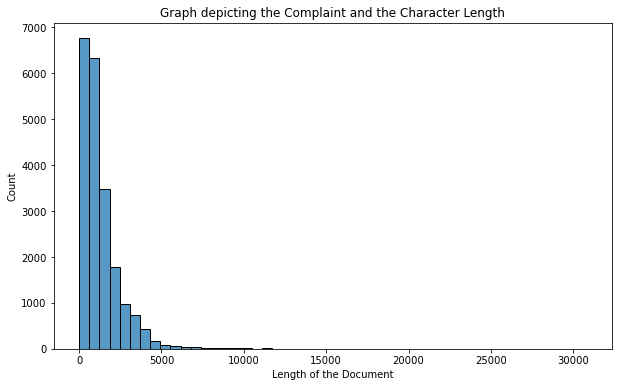

In [37]:
# Write your code here to visualise the data according to the 'Complaint' character length
comp_sent_len = [len(x) for x in df_clean['Complaint']]
noun_comp_sent_len = [len(x) for x in df_clean['complaint_POS_removed']]

print(len(comp_sent_len))
print(len(noun_comp_sent_len))

plt.figure(figsize=(10,6))
sns.histplot(comp_sent_len, bins= 50)
plt.title("Graph depicting the Complaint and the Character Length")
plt.xlabel("Length of the Document")
plt.show()

#### Find the top 40 words by frequency among all the articles after processing the text.

Text(0.5, 1.0, 'Most frequent words in complaints after processing')

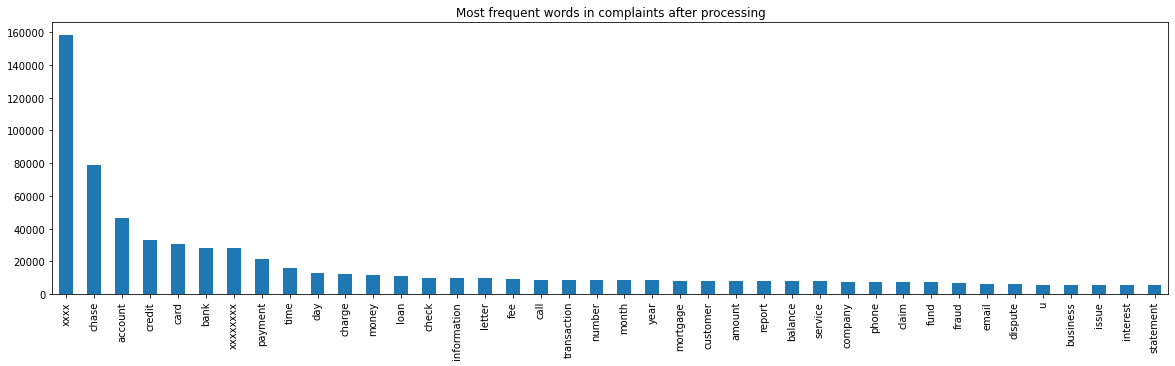

In [38]:
# Most frequent words in the processed complaints

most_freq=[]
for complaint in df_clean['complaint_POS_removed']:
    for word in complaint.split(' '):
        if len(word.strip())!=0:
            most_freq.append(word)

plt.figure(figsize=(20, 5)) 
pd.DataFrame(most_freq)[0].value_counts().head(40).plot(kind='bar')
plt.title("Most frequent words in complaints after processing")

In [39]:
# installing wordcloud to visualize the top xx words of the text corpus
!pip install wordcloud

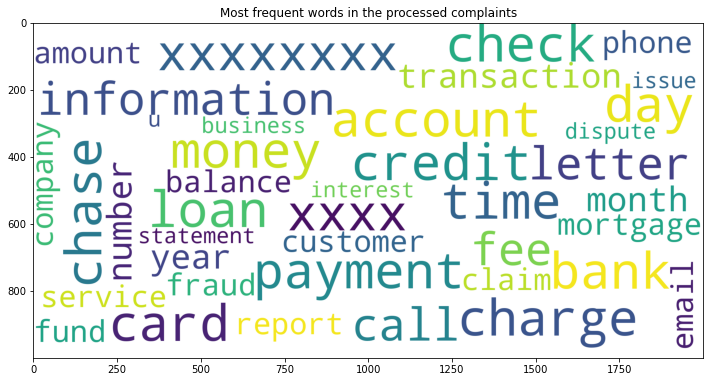

In [40]:
from wordcloud import WordCloud

plt.figure(figsize=(12, 12))
wordcloud = WordCloud(background_color = 'white', width = 2000, height = 1000, max_words = 50, contour_width = 3, colormap = 'viridis', max_font_size = 150, contour_color = 'steelblue', random_state = 0)

most_freq_words = pd.DataFrame(most_freq)[0].value_counts().head(40).index
wordcloud.generate(' '.join([w for w in most_freq_words]))

plt.imshow(wordcloud)
plt.title("Most frequent words in the processed complaints")
plt.show()

In [41]:
#Removing -PRON- from the text corpus
df_clean['Complaint_clean'] = df_clean['complaint_POS_removed'].str.replace('-PRON-', '')

In [42]:
df_clean.head()

,Complaint,Lem_complaint,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name xxxx xxxx chase bank cardmember s...,morning name xxxx xxxx chase bank cardmember s...
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade a...,xxxx xxxx card agent anniversary date agent in...,xxxx xxxx card agent anniversary date agent in...
2,chase card was reported on however fraudulent...,chase card reported however fraudulent appli...,chase card application identity consent servic...,chase card application identity consent servic...
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across...,book xxxx xxxx ticket offer ticket reward card...,book xxxx xxxx ticket offer ticket reward card...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account f...,son check deposit chase account fund clear cha...,son check deposit chase account fund clear cha...


In [43]:
# storing the dataframe in a temp variable
df_temp2 = df_clean

#### Find the top unigrams,bigrams and trigrams by frequency among all the complaints after processing the text.

In [44]:
#Write your code here to find the top 30 unigram frequency among the complaints in the cleaned datafram(df_clean). 

# Use the CountVectorizer function to get the unigram words
def get_unigrams(docs, n):
    vector = CountVectorizer(ngram_range=(1, 1), stop_words='english').fit(docs)
    bow = vector.transform(docs)
    
    # frequency of each unigram is calculated using the BagOfWords model
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vector.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# get the list of unigrams by calling the above defined function
unigrams = get_unigrams(df_clean['complaint_POS_removed'], 30)

In [45]:
#Print the top 10 words in the unigram frequency
unigrams_df = pd.DataFrame(unigrams, columns=['word', 'count'])
unigrams_df.head(10)

,word,count
0,xxxx,158223
1,chase,78877
2,account,46781
3,credit,33027
4,card,30418
5,bank,28192
6,xxxxxxxx,27899
7,payment,21164
8,time,16007
9,day,12967


In [46]:
#Write your code here to find the top 30 bigram frequency among the complaints in the cleaned datafram(df_clean). 

def get_bigrams(docs, n):
    vector = CountVectorizer(ngram_range=(2, 2), stop_words='english').fit(docs)
    bow = vector.transform(docs)
    
    # frequency of each bigram is calculated using the BagOfWords model
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vector.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# get the list of bigram words and frequency by calling the above func
bigrams = get_bigrams(df_clean['complaint_POS_removed'], 30)

In [47]:
#Print the top 10 words in the bigram frequency
bigrams_df = pd.DataFrame(bigrams, columns=['word', 'count'])
bigrams_df.head(10)

,word,count
0,xxxx xxxx,71504
1,chase bank,12940
2,credit card,12864
3,xxxx chase,6340
4,xxxxxxxx xxxx,4099
5,account chase,4063
6,chase xxxx,4011
7,credit report,3876
8,chase credit,3559
9,account xxxx,3470


In [48]:
#Write your code here to find the top 30 trigram frequency among the complaints in the cleaned datafram(df_clean). 
def get_trigrams(docs, n):
    vector = CountVectorizer(ngram_range=(3, 3), stop_words='english').fit(docs)
    bow = vector.transform(docs)
    
    # frequency of each trigram is calculated using the BagOfWords model
    sum_words = bow.sum(axis=0) 
    words_freq = [(word, sum_words[0, i]) for word, i in vector.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

# get the list of trigram words and frequency by calling the above func
trigrams = get_trigrams(df_clean['complaint_POS_removed'], 30)

In [49]:
#Print the top 10 words in the trigram frequency
trigrams_df = pd.DataFrame(trigrams, columns=['word', 'count'])
trigrams_df.head(10)

,word,count
0,xxxx xxxx xxxx,35035
1,xxxx xxxx chase,2764
2,chase credit card,2419
3,jp morgan chase,2304
4,xxxxxxxx xxxx xxxx,2043
5,xxxx xxxx xxxxxxxx,1599
6,chase xxxx xxxx,1585
7,account xxxx xxxx,1411
8,chase bank xxxx,1296
9,xxxx credit card,1213


## The personal details of customer has been masked in the dataset with xxxx. Let's remove the masked text as this will be of no use for our analysis

In [50]:
# remove the xxxx terms from the compalints column
df_clean['complaint_POS_removed'] = df_clean['complaint_POS_removed'].str.replace('xxxx','')
df_clean['Complaint_clean'] = df_clean['Complaint_clean'].str.replace('xxxx','')

In [51]:
#All masked texts has been removed
df_clean.head()

,Complaint,Lem_complaint,complaint_POS_removed,Complaint_clean
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase bank cardmember service c...,morning name chase bank cardmember service c...
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade a...,card agent anniversary date agent informatio...,card agent anniversary date agent informatio...
2,chase card was reported on however fraudulent...,chase card reported however fraudulent appli...,chase card application identity consent servic...,chase card application identity consent servic...
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across...,book ticket offer ticket reward card informa...,book ticket offer ticket reward card informa...
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account f...,son check deposit chase account fund clear cha...,son check deposit chase account fund clear cha...


In [52]:
df_temp3=df_clean

## Feature Extraction
Convert the raw texts to a matrix of TF-IDF features

**max_df** is used for removing terms that appear too frequently, also known as "corpus-specific stop words"
max_df = 0.95 means "ignore terms that appear in more than 95% of the complaints"

**min_df** is used for removing terms that appear too infrequently
min_df = 2 means "ignore terms that appear in less than 2 complaints"

In [53]:
#Write your code here to initialise the TfidfVectorizer 

from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    min_df=2,
    max_df=0.95,
    stop_words='english',
    max_features=5000,
    ngram_range=(1, 3)
)

#### Create a document term matrix using fit_transform

The contents of a document term matrix are tuples of (complaint_id,token_id) tf-idf score:
The tuples that are not there have a tf-idf score of 0

In [54]:
#Write your code here to create the Document Term Matrix by transforming the complaints column present in df_clean.
tfidf = tfidf_vectorizer.fit_transform(df_clean['complaint_POS_removed'])
features = tfidf_vectorizer.get_feature_names()

/Users/labuser/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [57]:
# get the list of features 
len(features)
features[0:30]

['ability',
 'abuse',
 'acceptance',
 'access',
 'access account',
 'access account chase',
 'access bank',
 'access chase',
 'access credit',
 'access fund',
 'access information',
 'access money',
 'accident',
 'accommodation',
 'accordance',
 'account',
 'account access',
 'account access account',
 'account account',
 'account account account',
 'account account balance',
 'account account bank',
 'account account chase',
 'account account credit',
 'account account day',
 'account account money',
 'account account number',
 'account action',
 'account activity',
 'account addition']

## Topic Modelling using NMF

Non-Negative Matrix Factorization (NMF) is an unsupervised technique so there are no labeling of topics that the model will be trained on. The way it works is that, NMF decomposes (or factorizes) high-dimensional vectors into a lower-dimensional representation. These lower-dimensional vectors are non-negative which also means their coefficients are non-negative.

In this task you have to perform the following:

* Find the best number of clusters 
* Apply the best number to create word clusters
* Inspect & validate the correction of each cluster wrt the complaints 
* Correct the labels if needed 
* Map the clusters to topics/cluster names

In [59]:
from sklearn.decomposition import NMF

## Manual Topic Modeling
You need to do take the trial & error approach to find the best num of topics for your NMF model.

The only parameter that is required is the number of components i.e. the number of topics we want. This is the most crucial step in the whole topic modeling process and will greatly affect how good your final topics are.

In [60]:
#Load your nmf_model with the n_components i.e 5
num_topics = 5 #write the value you want to test out

#keep the random_state =40
nmf_model = NMF(n_components=num_topics, random_state=40) #write your code here
len(tfidf_vectorizer.get_feature_names())

/Users/labuser/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



5000

In [61]:
W = nmf_model.fit_transform(tfidf)  # Document-Topic matrix
H = nmf_model.components_           # Topic-Term matrix

/Users/labuser/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning:

The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).



In [62]:
#Print the Top15 words for each of the topics
words = np.array(tfidf_vectorizer.get_feature_names())
topic_words = pd.DataFrame(np.zeros((num_topics, 15)), index=[f'Topic {i + 1}' for i in range(num_topics)],
                           columns=[f'Word {i + 1}' for i in range(15)]).astype(str)
for i in range(num_topics):
    ix = H[i].argsort()[::-1][:15]
    topic_words.iloc[i] = words[ix]

topic_words

/Users/labuser/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9,Word 10,Word 11,Word 12,Word 13,Word 14,Word 15
Topic 1,account,bank,chase,check,money,chase bank,fund,transaction,deposit,day,branch,account chase,claim,bank account,number
Topic 2,card,credit,credit card,chase,charge,chase credit,chase credit card,dispute,card chase,purchase,company,service,merchant,balance,chase card
Topic 3,loan,mortgage,chase,modification,home,property,morgan,jp,jp morgan,year,foreclosure,document,morgan chase,letter,jp morgan chase
Topic 4,credit,report,inquiry,credit report,inquiry credit,inquiry credit report,bureau,debt,credit bureau,reporting,account,score,information,jpmcb,report credit
Topic 5,payment,payment payment,balance,fee,month,payment chase,chase payment,statement,chase,payment account,pay,time,day,account payment,auto


In [63]:
#Create the best topic for each complaint in terms of integer value 0,1,2,3 & 4
topic_mapping = {
    'Topic 1' : 0,
    'Topic 2' : 1,
    'Topic 3' : 2,
    'Topic 4' : 3,
    'Topic 5' : 4
}

In [64]:
W = pd.DataFrame(W, columns=[f'Topic {i+1}' for i in range(num_topics)])
W['max_topic'] = W.apply(lambda x: topic_mapping.get(x.idxmax()) if x.idxmax() in topic_mapping.keys() else '4', axis=1)
W[pd.notnull(W['max_topic'])].head(10)

,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,max_topic
0,0.025004,0.005840,0.018750,0.013200,0.004774,0
1,0.006788,0.013897,0.002745,0.001466,0.001843,1
2,0.000000,0.033846,0.001465,0.022950,0.000000,1
3,0.020104,0.024061,0.015707,0.058109,0.000000,3
4,0.062274,0.000000,0.004099,0.000000,0.000000,0
5,0.000000,0.000000,0.000000,0.112320,0.000000,3
6,0.055141,0.002470,0.008266,0.000000,0.011497,0
7,0.001640,0.005707,0.037416,0.000000,0.054719,4
8,0.038095,0.019250,0.017698,0.008695,0.001850,0
9,0.000000,0.052978,0.000000,0.067756,0.000000,3


In [65]:
#Assign the best topic to each of the cmplaints in Topic Column
df_clean['Topic'] = W['max_topic'].apply(lambda x:int(x))#write your code to assign topics to each rows.

In [66]:
df_clean.head(10)

,Complaint,Lem_complaint,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase bank cardmember service c...,morning name chase bank cardmember service c...,0
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade a...,card agent anniversary date agent informatio...,card agent anniversary date agent informatio...,1
2,chase card was reported on however fraudulent...,chase card reported however fraudulent appli...,chase card application identity consent servic...,chase card application identity consent servic...,1
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across...,book ticket offer ticket reward card informa...,book ticket offer ticket reward card informa...,3
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account f...,son check deposit chase account fund clear cha...,son check deposit chase account fund clear cha...,0
5,can you please remove inquiry,please remove inquiry,inquiry,inquiry,3
6,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,jp morgan chase account debit card tuesday thu...,jp morgan chase account debit card tuesday thu...,0
7,during the summer months i experience a declin...,summer month experience decline income due emp...,summer month experience income employment mont...,summer month experience income employment mont...,4
8,on xxxx i made a payment to an online retail...,xxxx made payment online retailer using ch...,payment retailer chase pay chase website sca...,payment retailer chase pay chase website sca...,0
9,i have a chase credit card which is incorrectl...,chase credit card incorrectly reporting data c...,chase credit card datum credit report company ...,chase credit card datum credit report company ...,3


In [67]:
#Print the first 5 Complaint for each of the Topics
df_clean_topic = df_clean.groupby('Topic').head(5)
df_clean_topic.sort_values('Topic')

,Complaint,Lem_complaint,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase bank cardmember service c...,morning name chase bank cardmember service c...,0
10,mishandling of this account by chase auto and ...,mishandling account chase auto xxxx,account chase auto,account chase auto,0
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account f...,son check deposit chase account fund clear cha...,son check deposit chase account fund clear cha...,0
8,on xxxx i made a payment to an online retail...,xxxx made payment online retailer using ch...,payment retailer chase pay chase website sca...,payment retailer chase pay chase website sca...,0
6,with out notice jp morgan chase restricted my ...,notice jp morgan chase restricted account debi...,jp morgan chase account debit card tuesday thu...,jp morgan chase account debit card tuesday thu...,0
21,i am a senior citizen that has been scammed by...,senior citizen scammed several company xxxx xx...,citizen company time share company credit ca...,citizen company time share company credit ca...,1
16,xxxx xxxx a sofa love seat table and chairs an...,xxxx xxxx sofa love seat table chair never del...,sofa seat table chair debit card bank visa c...,sofa seat table chair debit card bank visa c...,1
14,my chase amazon card was declined for a cateri...,chase amazon card declined catering order plac...,chase amazon card catering order brother funer...,chase amazon card catering order brother funer...,1
2,chase card was reported on however fraudulent...,chase card reported however fraudulent appli...,chase card application identity consent servic...,chase card application identity consent servic...,1
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade a...,card agent anniversary date agent informatio...,card agent anniversary date agent informatio...,1


#### After evaluating the mapping, if the topics assigned are correct then assign these names to the relevant topic:
- Bank Account services
- Credit card or prepaid card
- Theft/Dispute Reporting
- Mortgage/Loan
- Others

In [69]:
#Create the dictionary of Topic names and Topics

Topic_names = { 
                0 : "Bank account services",
                1 : "Credit Card/Prepaid Card",
                2 : "Mortgages/loans",
                3 : "Theft/Dispute reporting",
                4 : "Others"
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [72]:
df_clean.head()

,Complaint,Lem_complaint,complaint_POS_removed,Complaint_clean,Topic
0,good morning my name is xxxx xxxx and i apprec...,good morning name xxxx xxxx appreciate could h...,morning name chase bank cardmember service c...,morning name chase bank cardmember service c...,Bank account services
1,i upgraded my xxxx xxxx card in and was told ...,upgraded xxxx xxxx card told agent upgrade a...,card agent anniversary date agent informatio...,card agent anniversary date agent informatio...,Credit Card/Prepaid Card
2,chase card was reported on however fraudulent...,chase card reported however fraudulent appli...,chase card application identity consent servic...,chase card application identity consent servic...,Credit Card/Prepaid Card
3,on while trying to book a xxxx xxxx ticket ...,trying book xxxx xxxx ticket came across...,book ticket offer ticket reward card informa...,book ticket offer ticket reward card informa...,Theft/Dispute reporting
4,my grand son give me check for i deposit it i...,grand son give check deposit chase account f...,son check deposit chase account fund clear cha...,son check deposit chase account fund clear cha...,Bank account services


In [70]:
df_temp4  = df_clean

In [71]:
df_clean.shape

(21072, 5)

## Supervised model to predict any new complaints to the relevant Topics.

You have now build the model to create the topics for each complaints.Now in the below section you will use them to classify any new complaints.

Since you will be using supervised learning technique we have to convert the topic names to numbers(numpy arrays only understand numbers)

In [73]:
#Create the dictionary again of Topic names and Topics

Topic_names = { 
    "Bank account services" : 0,
    "Credit Card/Prepaid Card" : 1,
    "Mortgages/loans" : 2,
    "Theft/Dispute reporting" : 3,
    "Others" : 4
}
#Replace Topics with Topic Names
df_clean['Topic'] = df_clean['Topic'].map(Topic_names)

In [74]:
df_clean.shape

(21072, 5)

In [77]:
#Keep the columns"complaint_what_happened" & "Topic" only in the new dataframe --> training_data
training_data = df_clean[["Complaint", "Topic"]]

In [78]:
training_data.head()

,Complaint,Topic
0,good morning my name is xxxx xxxx and i apprec...,0
1,i upgraded my xxxx xxxx card in and was told ...,1
2,chase card was reported on however fraudulent...,1
3,on while trying to book a xxxx xxxx ticket ...,3
4,my grand son give me check for i deposit it i...,0


In [79]:
training_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21072 entries, 0 to 21071
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Complaint  21072 non-null  object
 1   Topic      21072 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 329.4+ KB


#### Apply the supervised models on the training data created. In this process, you have to do the following:
* Create the vector counts using Count Vectoriser
* Transform the word vecotr to tf-idf
* Create the train & test data using the train_test_split on the tf-idf & topics


In [81]:
#Write your code to get the Vector count
vectorizer = CountVectorizer(ngram_range=(1,3), stop_words='english', max_df=0.95, min_df=0.02)
vector = vectorizer.fit_transform(training_data['Complaint'])

print(vector.toarray())


[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 1 1 0]
 [0 0 0 ... 3 1 0]]


In [82]:
#Write your code here to transform the word vector to tf-idf
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer =TfidfTransformer(use_idf=True).fit(vector)
word_vect = tfidf_transformer.transform(vector)
word_vect.shape

(21072, 820)

You have to try atleast 3 models on the train & test data from these options:
* Logistic regression
* Decision Tree
* Random Forest
* Naive Bayes (optional)

**Using the required evaluation metrics judge the tried models and select the ones performing the best**

In [ ]:
# Write your code here to build any 3 models and evaluate them using the required metrics





In [84]:
# Check the dataframe columns
columns = vectorizer.get_feature_names()
print('feature columns ::', len(columns))
print('\n',columns)

feature columns :: 820

 ['ability', 'able', 'absolutely', 'accept', 'accepted', 'access', 'according', 'account', 'account called', 'account chase', 'account chase bank', 'account closed', 'account number', 'account xxxx', 'account xxxx xxxx', 'account xxxxxxxx', 'accounts', 'act', 'action', 'actions', 'activity', 'actually', 'add', 'added', 'addition', 'additional', 'address', 'advised', 'agencies', 'agency', 'agent', 'ago', 'agreed', 'agreement', 'alert', 'allow', 'allowed', 'amounts', 'annual', 'answer', 'app', 'apparently', 'appears', 'application', 'applied', 'apply', 'approved', 'approximately', 'ask', 'asked', 'asking', 'assist', 'assistance', 'assured', 'atm', 'attached', 'attempt', 'attempted', 'attempts', 'attorney', 'authorization', 'authorize', 'authorized', 'auto', 'available', 'avoid', 'aware', 'away', 'bad', 'balance', 'bank', 'bank account', 'bank chase', 'bank xxxx', 'bank xxxx xxxx', 'banker', 'banking', 'bankruptcy', 'banks', 'based', 'began', 'beginning', 'behalf',

/Users/labuser/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [85]:
word_vect_df = pd.DataFrame(word_vect.toarray(),columns=vectorizer.get_feature_names(),index=training_data.index)
word_vect_df.head()

,ability,able,absolutely,accept,accepted,access,according,account,account called,account chase,account chase bank,account closed,account number,account xxxx,account xxxx xxxx,account xxxxxxxx,accounts,act,action,actions,activity,actually,add,added,addition,additional,address,advised,agencies,agency,agent,ago,agreed,agreement,alert,allow,allowed,amounts,annual,answer,app,apparently,appears,application,applied,apply,approved,approximately,ask,asked,asking,assist,assistance,assured,atm,attached,attempt,attempted,attempts,attorney,authorization,authorize,authorized,auto,available,avoid,aware,away,bad,balance,bank,bank account,bank chase,bank xxxx,bank xxxx xxxx,banker,banking,bankruptcy,banks,based,began,beginning,behalf,believe,best,better,billing,bills,bonus,branch,branch manager,branch xxxx,bureau,bureaus,business,business days,buy,ca,ca nt,called,called chase,called xxxx,called xxxx xxxx,calling,calls,came,cancel,cancelled,car,card,card account,card chase,card company,card services,card xxxx,cards,care,case,cash,cause,caused,causing,cfpb,change,changed,charge,charge xxxx,charged,charges,charging,chase,chase account,chase bank,chase bank xxxx,chase branch,chase card,chase chase,chase checking,chase closed,chase credit,chase credit card,chase customer,chase customer service,chase did,chase freedom,chase mortgage,chase representative,chase said,chase sent,chase told,chase xxxx,chase xxxx xxxx,chase xxxxxxxx,check,check xxxx,checked,checking,checking account,checks,claim,claimed,claiming,claims,clear,cleared,clearly,close,close account,closed,closed account,closing,code,collect,collection,come,communication,companies,company,complaint,complaint chase,complaints,complete,completed,completely,concern,confirm,confirmation,confirmed,consumer,consumers,contact,contact chase,contacted,contacted chase,contacted xxxx,contacting,continue,continued,contract,conversation,copies,copy,correct,correspondence,cost,couple,course,court,cover,credit,credit account,credit bureaus,credit card,credit card account,credit card chase,credit card company,credit card xxxx,credit cards,credit report,credit reporting,credit reports,credit score,credited,current,currently,customer,customer service,customers,date,dated,dates,day,days,days later,deal,debit,debit card,debt,decided,decision,declined,denied,department,deposit,deposited,deposits,dept,despite,details,did,did nt,did receive,didnt,different,direct,directly,discovered,dispute,disputed,document,documentation,documents,does,doesnt,doing,dollars,dont,early,email,emailed,emails,employee,employees,end,ended,ending,ending xxxx,entire,error,escrow,evidence,executive,executive office,explain,explained,explanation,extra,extremely,fact,failed,fair,false,family,far,fault,fax,federal,fee,feel,fees,file,filed,filing,final,finally,finance,financial,fine,fix,fixed,follow,followed,following,forced,foreclosure,form,forward,fraud,fraud department,fraudulent,free,freedom,friday,funds,future,gave,getting,given,giving,going,gone,good,got,government,happen,happened,hard,having,hear,heard,held,help,high,higher,history,hold,holder,holding,home,honor,hour,hours,house,husband,id,idea,identity,identity theft,illegal,im,immediately,included,including,income,incorrect,indicated,info,inform,information,informed,initial,initially,initiated,inquiries,inquiry,instead,institution,insurance,investigate,investigation,involved,issue,issued,issues,item,items,ive,job,jp,jp morgan,jp morgan chase,jpmorgan,jpmorgan chase,just,kept,kind,knew,know,knowledge,lack,large,late,late fees,late payment,later,law,leave,left,legal,lender,let,let know,letter,letter chase,letters,life,like,limit,line,listed,little,live,loan,loan modification,loan xxxx,loans,local,located,location,long,longer,look,looked,looking,loss,lost,lot,lower,mail,mailed,make,make payment,makes,making,manager,matter,means,mentioned,merchant,message,messages,minimum,minutes,missed,missing,mistake,modification,monday,money,money account,month,monthly,months,morgan,morgan chase,morgan c

In [86]:
## assign the label to be matched
word_vect_df["Topic"] = training_data["Topic"]

In [87]:
# common function to evaluate the matrix
from sklearn import metrics

def evaluate_accuracy(y_actual,y_pred):
       
    # Confusion matrix
    confusion = metrics.confusion_matrix(y_actual, y_pred)

    # Metrics calculation
    accuracy = metrics.accuracy_score(y_actual,y_pred)
    clf_report = metrics.classification_report(y_actual,y_pred)   # Sklearn classification report
    
    print("Accuracy   : " + str(accuracy))
    print("\nConfusion matrix:\n", confusion)
    print("\nClassificationReport:")
    print(clf_report)
    
    return accuracy

### Train test split


In [88]:
from sklearn.model_selection import train_test_split

X= word_vect_df.drop(['Topic'], axis=1)
y= word_vect_df['Topic']

# Splitting the data into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.70, test_size=0.30, random_state=40, stratify=y)


### Logistic Regression


In [90]:
from sklearn.linear_model import LogisticRegression
logistic_regression = LogisticRegression(solver='lbfgs', max_iter=1000)
logistic_regression.fit(X_train, y_train)

y_train_pred = logistic_regression.predict(X_train)
y_pred = logistic_regression.predict(X_test)

In [91]:
lr_training_accuracy = evaluate_accuracy(y_train.values,y_train_pred)


Accuracy   : 0.9693559322033898

Confusion matrix:
 [[4260   48   24    2    9]
 [  38 4256    8   14    4]
 [  42   32 2577   13    9]
 [  33   35   19 1585    6]
 [  43   32   36    5 1620]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.96      0.98      0.97      4343
           1       0.97      0.99      0.98      4320
           2       0.97      0.96      0.97      2673
           3       0.98      0.94      0.96      1678
           4       0.98      0.93      0.96      1736

    accuracy                           0.97     14750
   macro avg       0.97      0.96      0.97     14750
weighted avg       0.97      0.97      0.97     14750



In [92]:
lr_test_acc = evaluate_accuracy(y_test.values,y_pred)



Accuracy   : 0.9443214172730149

Confusion matrix:
 [[1791   35   31    1    4]
 [  34 1782   11   14   10]
 [  34   21 1077    4   10]
 [  15   28   12  656    8]
 [  30   22   21    7  664]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1862
           1       0.94      0.96      0.95      1851
           2       0.93      0.94      0.94      1146
           3       0.96      0.91      0.94       719
           4       0.95      0.89      0.92       744

    accuracy                           0.94      6322
   macro avg       0.95      0.93      0.94      6322
weighted avg       0.94      0.94      0.94      6322



### Decision Tree Classifier

In [93]:
from sklearn.tree import DecisionTreeClassifier

# Checking initial tree with standard params
dt = DecisionTreeClassifier(random_state=40, max_depth=10, min_samples_leaf = 10, class_weight="balanced")
dt.fit(X_train,y_train)

# predict the train and test
y_train_pred_dt  = dt.predict(X_train)
y_test_pred_dt = dt.predict(X_test)

# check for model accuracy
train_accuracy_dt = evaluate_accuracy(y_train.values, y_train_pred_dt)

Accuracy   : 0.8315932203389831

Confusion matrix:
 [[3513  312  321   90  107]
 [ 250 3487  273  202  108]
 [ 186   65 2273   63   86]
 [  46   65   75 1468   24]
 [  51   35   98   27 1525]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.87      0.81      0.84      4343
           1       0.88      0.81      0.84      4320
           2       0.75      0.85      0.80      2673
           3       0.79      0.87      0.83      1678
           4       0.82      0.88      0.85      1736

    accuracy                           0.83     14750
   macro avg       0.82      0.84      0.83     14750
weighted avg       0.84      0.83      0.83     14750



In [94]:
# check for test data accuracy
test_accuracy_dt = evaluate_accuracy(y_test.values,y_test_pred_dt)

Accuracy   : 0.7845618475166086

Confusion matrix:
 [[1428  161  158   56   59]
 [ 117 1436  125  108   65]
 [  85   38  924   41   58]
 [  30   42   57  567   23]
 [  24   27   67   21  605]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1862
           1       0.84      0.78      0.81      1851
           2       0.69      0.81      0.75      1146
           3       0.72      0.79      0.75       719
           4       0.75      0.81      0.78       744

    accuracy                           0.78      6322
   macro avg       0.77      0.79      0.78      6322
weighted avg       0.79      0.78      0.79      6322



#### Hyper parameter tuning 

In [95]:
from sklearn.model_selection import GridSearchCV

dt = DecisionTreeClassifier(random_state = 40, class_weight="balanced")

# Create the parameter grid based on the results of random search 
params = {
    'max_depth': [5, 10, 15, 20],
    'min_samples_leaf': [5, 10, 20, 50],
    'criterion': ["entropy", "gini"]
}

grid_search = GridSearchCV(estimator = dt,param_grid = params,cv = 5, n_jobs=-1, verbose=1, scoring="accuracy", return_train_score=True)

In [96]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight='balanced',
                                              random_state=40),
             n_jobs=-1,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [5, 10, 15, 20],
                         'min_samples_leaf': [5, 10, 20, 50]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [97]:
# Get the results in tabular format
scores = grid_search.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,7.959956,0.215029,0.100398,0.026469,entropy,5,5,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.718983,0.693559,0.714915,0.727458,0.721356,0.715254,0.011583,25,0.739407,0.712966,0.726356,0.725085,0.721186,0.725000,0.008588
1,7.827176,0.192086,0.071243,0.017087,entropy,5,10,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.718983,0.693898,0.714237,0.727458,0.721356,0.715186,0.011464,26,0.739407,0.712966,0.726102,0.725085,0.721186,0.724949,0.008580
2,5.599248,1.804102,0.065134,0.026663,entropy,5,20,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.716610,0.693220,0.714915,0.725424,0.721017,0.714237,0.011126,27,0.738220,0.712034,0.726356,0.724492,0.721271,0.724475,0.008456
3,3.904777,0.036740,0.074362,0.018015,entropy,5,50,"{'criterion': 'entropy', 'max_depth': 5, 'min_...",0.718644,0.692203,0.710508,0.725424,0.716610,0.712678,0.011291,30,0.736356,0.710593,0.723898,0.721949,0.718390,0.722237,0.008397
4,6.029521,0.466570,0.047189,0.005992,entropy,10,5,"{'criterion': 'entropy', 'max_depth': 10, 'min...",0.781017,0.780000,0.780678,0.787119,0.789831,0.783729,0.003982,16,0.843644,0.849576,0.839492,0.844661,0.850169,0.845508,0.003967


In [98]:
grid_search.best_params_

{'criterion': 'gini', 'max_depth': 20, 'min_samples_leaf': 5}

In [99]:
dt_best = DecisionTreeClassifier(random_state=40, max_depth = 20, min_samples_leaf = 10, class_weight="balanced")
dt_best.fit(X_train,y_train)

y_train_pred_dt = dt_best.predict(X_train)
y_test_pred_dt = dt_best.predict(X_test)

In [100]:
train_accuracy_dt = evaluate_accuracy(y_train.values,y_train_pred_dt)


Accuracy   : 0.8803389830508475

Confusion matrix:
 [[3752  201  191   80  119]
 [ 172 3781  122  155   90]
 [ 108   44 2355   63  103]
 [  28   48   56 1519   27]
 [  27   33   71   27 1578]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.92      0.86      0.89      4343
           1       0.92      0.88      0.90      4320
           2       0.84      0.88      0.86      2673
           3       0.82      0.91      0.86      1678
           4       0.82      0.91      0.86      1736

    accuracy                           0.88     14750
   macro avg       0.87      0.89      0.88     14750
weighted avg       0.88      0.88      0.88     14750



In [101]:
train_accuracy_dt = evaluate_accuracy(y_test.values, y_test_pred_dt)


Accuracy   : 0.8086048718759886

Confusion matrix:
 [[1468  149  110   56   79]
 [ 114 1530   57   85   65]
 [  70   33  943   41   59]
 [  21   59   52  565   22]
 [  28   30   60   20  606]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1862
           1       0.85      0.83      0.84      1851
           2       0.77      0.82      0.80      1146
           3       0.74      0.79      0.76       719
           4       0.73      0.81      0.77       744

    accuracy                           0.81      6322
   macro avg       0.79      0.81      0.80      6322
weighted avg       0.81      0.81      0.81      6322



### Random forest classifier


In [102]:

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [103]:
rf = RandomForestClassifier(random_state=42, class_weight="balanced")

folds = StratifiedKFold(n_splits=4, shuffle = True, random_state=40)

param_grid = {
     'max_depth': [5, 10, 20],
     'min_samples_leaf': [10, 20, 50, 100],
     'n_estimators': [15, 20, 25, 30],
     'min_samples_split': range(10, 30, 50),
     'max_features': [5, 10, 15],
     'criterion': ["gini"]
}

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = folds, verbose = 1, scoring="accuracy", return_train_score=True)

In [104]:
# Fit the grid search to the data, This step may take a lot of time
grid_search.fit(X_train, y_train)

Fitting 4 folds for each of 144 candidates, totalling 576 fits


GridSearchCV(cv=StratifiedKFold(n_splits=4, random_state=40, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=42),
             param_grid={'criterion': ['gini'], 'max_depth': [5, 10, 20],
                         'max_features': [5, 10, 15],
                         'min_samples_leaf': [10, 20, 50, 100],
                         'min_samples_split': range(10, 30, 50),
                         'n_estimators': [15, 20, 25, 30]},
             return_train_score=True, scoring='accuracy', verbose=1)

In [105]:
grid_search.best_score_


0.8595927489267268

In [106]:
rf_best = grid_search.best_estimator_
rf_best

RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=15,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=30, random_state=42)

In [107]:
rf_best.fit(X_train,y_train)


RandomForestClassifier(class_weight='balanced', max_depth=20, max_features=15,
                       min_samples_leaf=10, min_samples_split=10,
                       n_estimators=30, random_state=42)

In [108]:
y_train_pred_rf = rf_best.predict(X_train)
y_test_pred_rf = rf_best.predict(X_test)

In [109]:
train_accuracy_rf = evaluate_accuracy(y_train.values,y_train_pred_rf)


Accuracy   : 0.9003389830508475

Confusion matrix:
 [[3957  131  145   48   62]
 [ 183 3848   65  137   87]
 [  78   41 2420   69   65]
 [  20   35   26 1572   25]
 [  68   50  101   34 1483]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      4343
           1       0.94      0.89      0.91      4320
           2       0.88      0.91      0.89      2673
           3       0.85      0.94      0.89      1678
           4       0.86      0.85      0.86      1736

    accuracy                           0.90     14750
   macro avg       0.89      0.90      0.89     14750
weighted avg       0.90      0.90      0.90     14750



In [110]:
train_accuracy_rf = evaluate_accuracy(y_test.values, y_test_pred_rf)


Accuracy   : 0.859379943055995

Confusion matrix:
 [[1620   85   90   25   42]
 [  94 1603   30   76   48]
 [  40   28 1004   34   40]
 [  10   21   17  643   28]
 [  59   37   69   16  563]]

ClassificationReport:
              precision    recall  f1-score   support

           0       0.89      0.87      0.88      1862
           1       0.90      0.87      0.88      1851
           2       0.83      0.88      0.85      1146
           3       0.81      0.89      0.85       719
           4       0.78      0.76      0.77       744

    accuracy                           0.86      6322
   macro avg       0.84      0.85      0.85      6322
weighted avg       0.86      0.86      0.86      6322

